# İçindekiler:
## - Time Series with Linear Regression
   - ## Time Series Fastapi (For Linear Regression model) 
## - Time Series with Prophet Library
## - Oil Prediction for States

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import preprocessing
import uvicorn
from fastapi import FastAPI
import pickle
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


## Time Series With Linear Regression 

In [ ]:
df1 = pd.read_csv(path)
df1['Período'] = df1['Período']+'/01'
df1['Período'] = pd.to_datetime(df1['Período'])
pd.set_option('display.float_format', lambda df1: '%.0f' % df1)

In [ ]:
df1

,Estado,Bacia,NP_ANP,NP_Operador,Campo,Operador,Número do Contrato,Período,Óleo (bbl/dia),Condensado (bbl/dia),Petróleo (bbl/dia),GN_Associado,GN_Não associado,GN_Gás Total,Volume Gás,Água (bbl/dia),Instalação Destino,Tipo Instalação,Tempo de Produção (hs por mês)
0,Sergipe,Sergipe,7-GA-7D-SES,7GA 0007D SES,GUARICEMA,Petrobras,480000038399796,2005-01-01,77,0,77,0,0,0,0,7,NaN,NaN,31
1,Sergipe,Sergipe,7-GA-66D-SES,7GA66DSES,GUARICEMA,Petrobras,480000038399796,2005-01-01,71,0,71,0,0,0,0,144,NaN,NaN,31
2,Sergipe,Sergipe,7-GA-35D-SES,7GA 0035D SES,GUARICEMA,Petrobras,480000038399796,2005-01-01,0,0,0,0,0,0,0,0,NaN,NaN,31
3,Sergipe,Sergipe,7-GA-30-SES,7GA 0030 SES,GUARICEMA,Petrobras,480000038399796,2005-01-01,0,0,0,0,0,0,0,0,NaN,NaN,31
4,Sergipe,Sergipe,7-GA-58D-SES,7GA 0058D SES,GUARICEMA,Petrobras,480000038399796,2005-01-01,423,0,423,0,0,0,0,2,NaN,NaN,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109396,Bahia,Recôncavo,7-BA-73-BA,7BA 0073 BA,BURACICA,Petrobras,480000036359746,2022-03-01,9,0,9,0,0,0,0,739,Estação Coletora Pereira,INSTALACAO EMB/DESEMB,698
2109397,Bahia,Recôncavo,7-BA-75-BA,7BA 0075 BA,BURACICA,Petrobras,480000036359746,2022-03-01,0,0,0,0,0,0,0,0,NaN,NaN,0
2109398,Bahia,Recôncavo,7-BA-81-BA,7BA 0081 BA,BURACICA,Petrobras,480000036359746,2022-03-01,1,0,1,0,0,0,0,143,Estação Coletora Lameiro,INSTALACAO EMB/DESEMB,41
2109399,Bahia,Recôncavo,7-BA-92-BA,7BA 0092 BA,BURACICA,Petrobras,480000036359746,2022-03-01,0,0,0,0,0,0,0,0,NaN,NaN,0


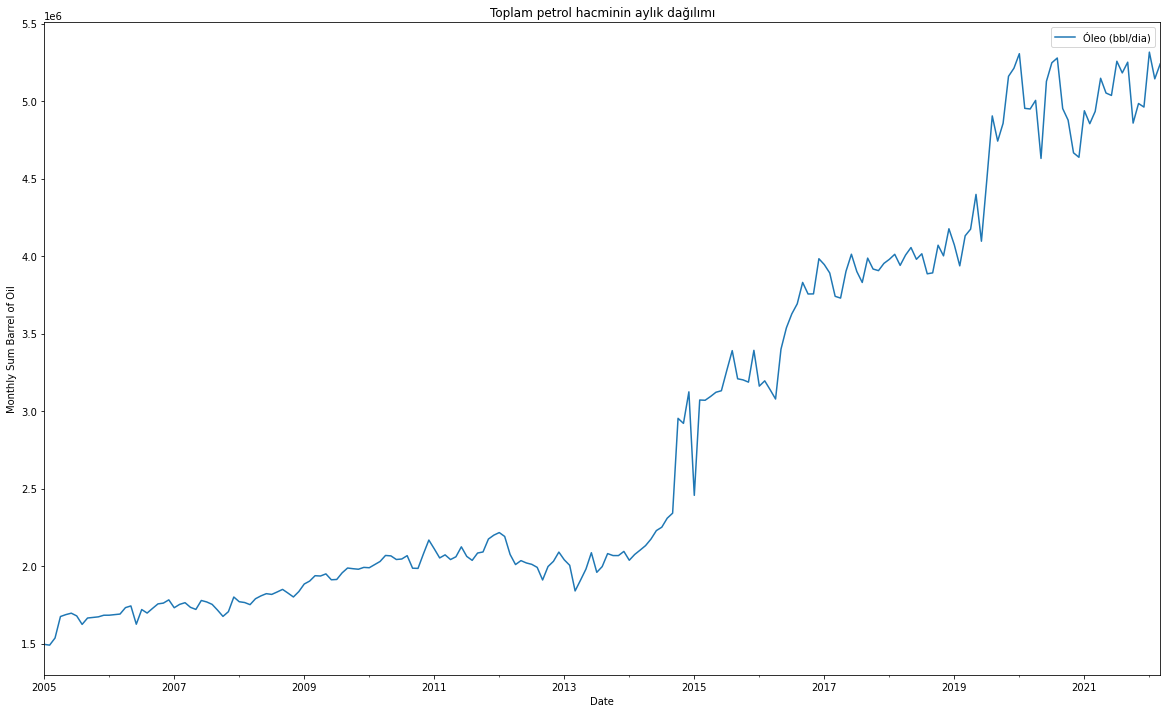

In [ ]:
df=df1
df = pd.DataFrame(df.groupby(['Período']).sum()['Óleo (bbl/dia)'])
df['Date']=df.index
df.index=np.arange(0,len(df),1)

ax = pd.DataFrame(df['Óleo (bbl/dia)']).set_index(df['Date']).plot(figsize=(20, 12))
ax.set_ylabel('Monthly Sum Barrel of Oil')
ax.set_xlabel('Date')
plt.title('Toplam petrol hacminin aylık dağılımı')
plt.show()

In [ ]:
# dataların grafikteki dağılımına bakarak, kırılma nedeniyle 2013-01-01 tarihinden sonrasını analiz için alıyoruz. 
# hem de eski tarihdeki veriler zaman serisi tahmininde hataları arttırabilir.

df = df[df['Date'] > '2013-01-01']
df.index = np.arange(0,len(df),1)
df.rename(columns={'Petróleo (bbl/dia)':'y'},inplace=True)

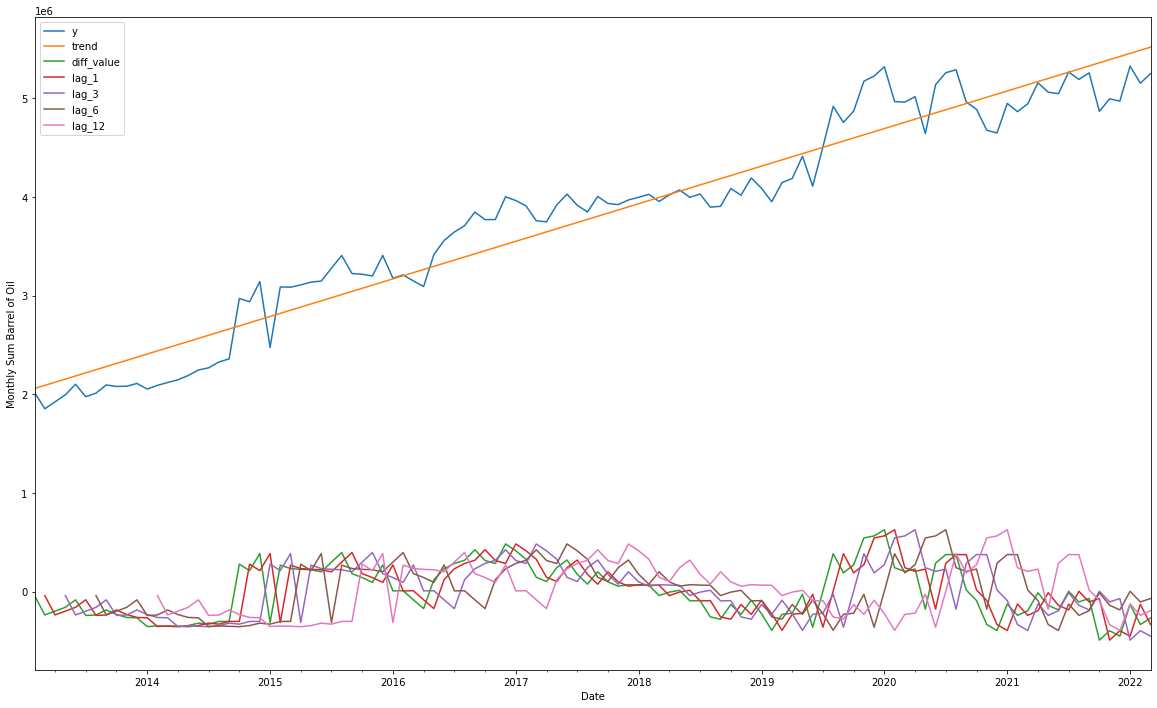

In [ ]:
# bazı değişkenlerin türetilmesi ve grafiği

y = np.array(pd.DataFrame(df.y)).reshape(-1,1)
x = np.array(pd.DataFrame(df.index.values)).reshape(-1,1)
ln_reg = LinearRegression().fit(x, y)
trend = []

for i in df.index:
    trend_value = ln_reg.predict([[df.index[i]]])
    trend.append(trend_value)

df['trend']=np.array(trend).reshape(len(trend),1)
df['diff_value'] = df['y'] - df['trend']
for r in [1,3,6,12]:
    df['lag_'+str(r)] = df['diff_value'].shift(r)

ax = df.set_index('Date').plot(figsize=(20, 12))
ax.set_ylabel('Monthly Sum Barrel of Oil')
ax.set_xlabel('Date')

plt.show()


In [ ]:
# tahmin etmek için model kurulması. 
# burada dikkat edilecek nokta; her bir tahmin edilen değer ait olduğu yılın değeri olarak atanır ve bir sonraki yılın tahmininde kullanılır.

month_pred = 12

for j in np.ones(month_pred):
    y = np.array(pd.DataFrame(df.y)).reshape(-1,1)
    x = np.array(pd.DataFrame(df.index.values)).reshape(-1,1)
    ln_reg = LinearRegression().fit(x, y)
    trend = []

    for i in df.index:
        trend_value = ln_reg.predict([[df.index[i]]])
        trend.append(trend_value)
    df['trend']=np.array(trend).reshape(len(trend),1)

    df['diff_value'] = df['y'] - df['trend']
    for r in [1,3,6,12]:
        df['lag_'+str(r)] = df['diff_value'].shift(r)
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    means = df.groupby('month').agg({'diff_value': 'mean'}).to_dict()['diff_value']
    df['monthavg'] = df['month'].map( means )
    df = pd.get_dummies(df, columns = ['year'])
    df.drop(columns=['trend','diff_value'],inplace=True)
    df['month'] = df['month'].astype(str).astype(int)

    df2 = df.loc[12:]
    df2.index = np.arange(0,len(df2),1)

    # define x and y

    y = df2['y']
    x = df2.drop(columns=['y','Date'])
    ln_reg = LinearRegression().fit(x,y)

    predicted_next = ln_reg.predict(np.array(x.tail(1)).reshape(1,-1))
    predicted_next
    new_date = pd.DataFrame(df['Date']).append(pd.DataFrame(df['Date']).tail(1) + pd.DateOffset(months=j),ignore_index=True)
    new_y = pd.DataFrame(df['y'].append(pd.Series(predicted_next),ignore_index=True))
    df = pd.DataFrame(pd.concat([new_date,new_y], axis=1))
    df.columns = ['Date','y']

print('Coefficients:', ln_reg.coef_)
print('İntercept:', ln_reg.intercept_)
print('Regr.Score:',ln_reg.score( x, y ))
print(df.tail(month_pred))

Coefficients: [ 5.89879988e-01  1.07190763e-01  7.71670866e-02 -4.70626242e-02
  3.18007764e+04  8.07513485e-01 -1.16415322e-10 -1.64481896e+06
 -1.26174436e+06 -8.53763810e+05 -5.40289756e+05 -2.19322977e+05
  2.61255391e+05  5.06751792e+05  8.72882560e+05  1.24052395e+06
  1.63852617e+06]
İntercept: 4059402.3957887287
Regr.Score: 0.9705558174249665
          Date       y
110 2022-04-01 5223090
111 2022-05-01 5282338
112 2022-06-01 5286644
113 2022-07-01 5344000
114 2022-08-01 5393434
115 2022-09-01 5441377
116 2022-10-01 5456623
117 2022-11-01 5514129
118 2022-12-01 5525942
119 2023-01-01 5611383
120 2023-02-01 5611383
121 2023-03-01 5632739


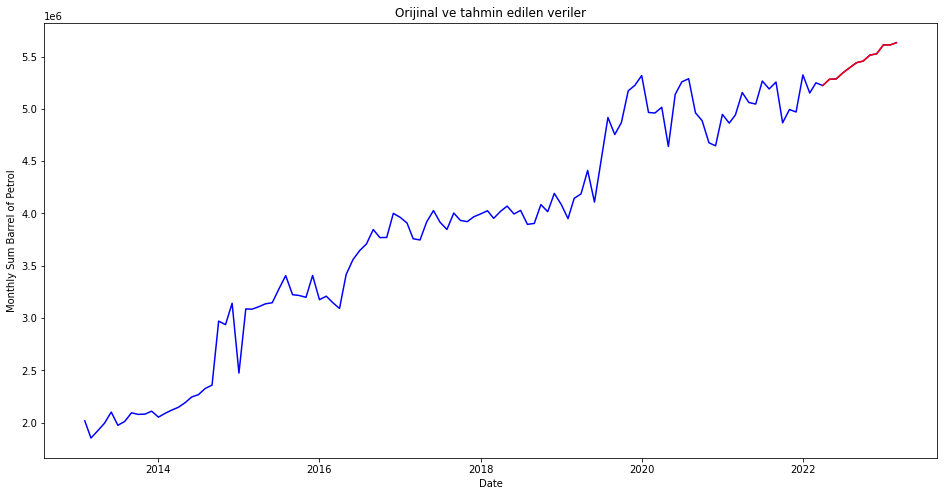

In [ ]:
# Orijinal değerler ve Linear regression yöntemi ile tahmin edilen değerlerin gösterimi

predict_values = df[df['Date']>'2022-03-01']
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df.set_index('Date'), color='b')
ax.plot(predict_values.set_index('Date'), color='r')
ax.set_ylabel('Monthly Sum Barrel of Petrol')
ax.set_xlabel('Date')
plt.title('Orijinal ve tahmin edilen veriler')
pl1 = plt.show()
pl1

### Time Series Fastapi (Linear Regression model)

In [ ]:
# Linear Regression ile kurulmuş modelin Fastapi ile kullanımı

filename = 'regres_ts_model.sav'
pickle.dump(ln_reg, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x,y)

def dataset(pclass):
    observation = {"pred_month": [month_pred]}

    dataframe = pd.DataFrame(data = observation)
    
    return dataframe

app = FastAPI()

pickle_model = open("regres_ts_model.sav", "rb")
model = pickle.load(pickle_model)

@app.post('/Predict Brasil Oil')
def predict_oil_volume(month_pred: int,):
    """   Brasil monthly oil prediction. 
    Date - monthly date
    y -monthly oil  
"""
    user_data = dataset(month_pred)
    
    
    prediction = model.predict(x)
    
    return { str(df.tail(month_pred)[['Date','y']])}

import nest_asyncio
nest_asyncio.apply()

if __name__ == '__main__':
    uvicorn.run(app, host = '127.0.0.1', port = 8000)

# http://127.0.0.1:8000/docs

INFO:     Started server process [5544]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:51484 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:51484 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:51483 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:51483 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:51483 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:51483 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:51489 - "POST /Predict%20Brasil%20Oil?month_pred=2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51493 - "POST /Predict%20Brasil%20Oil?month_pred=12 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [5544]


## Time Series With Prophet Library

In [ ]:
# Prophet library ile sonraki 24 ayın tahmin edilmesi

df=df1
df = pd.DataFrame(df.groupby(['Período']).sum()['Petróleo (bbl/dia)'])
df['Date']=df.index
df.index=np.arange(0,len(df),1)
df = df[df['Date'] > '2013-01-01']

df.index = np.arange(0,len(df),1)
df = df.rename(columns={'Petróleo (bbl/dia)': 'y',
                        'Date': 'ds'})

m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=24, freq='MS')
forecast = m.predict(future)
forecast

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-02-01,1795940,1538880,2073554,1795940,1795940,19080,19080,19080,19080,19080,19080,0,0,0,1815020
1,2013-03-01,1834725,1532314,2078400,1834725,1834725,-37947,-37947,-37947,-37947,-37947,-37947,0,0,0,1796778
2,2013-04-01,1877667,1555219,2130942,1877667,1877667,-32487,-32487,-32487,-32487,-32487,-32487,0,0,0,1845179
3,2013-05-01,1919223,1633507,2166866,1919223,1919223,-31347,-31347,-31347,-31347,-31347,-31347,0,0,0,1887875
4,2013-06-01,1962164,1699103,2274565,1962164,1962164,29505,29505,29505,29505,29505,29505,0,0,0,1991669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2023-11-01,5784935,5541916,6110071,5755127,5813927,43030,43030,43030,43030,43030,43030,0,0,0,5827965
130,2023-12-01,5808579,5656086,6221541,5776020,5840296,126081,126081,126081,126081,126081,126081,0,0,0,5934660
131,2024-01-01,5833011,5522792,6109639,5798330,5867409,-28281,-28281,-28281,-28281,-28281,-28281,0,0,0,5804730
132,2024-02-01,5857443,5556331,6089190,5820097,5894319,-41357,-41357,-41357,-41357,-41357,-41357,0,0,0,5816086


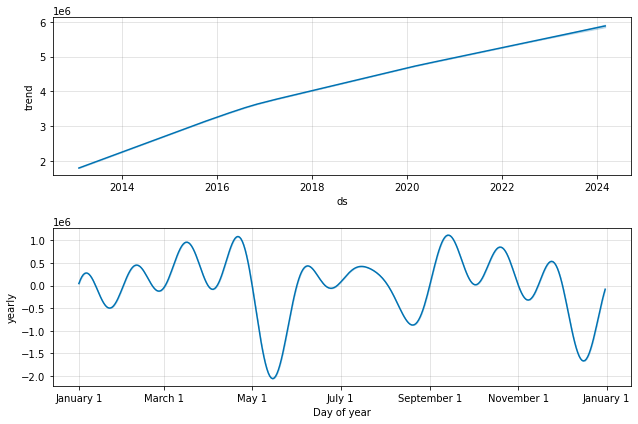

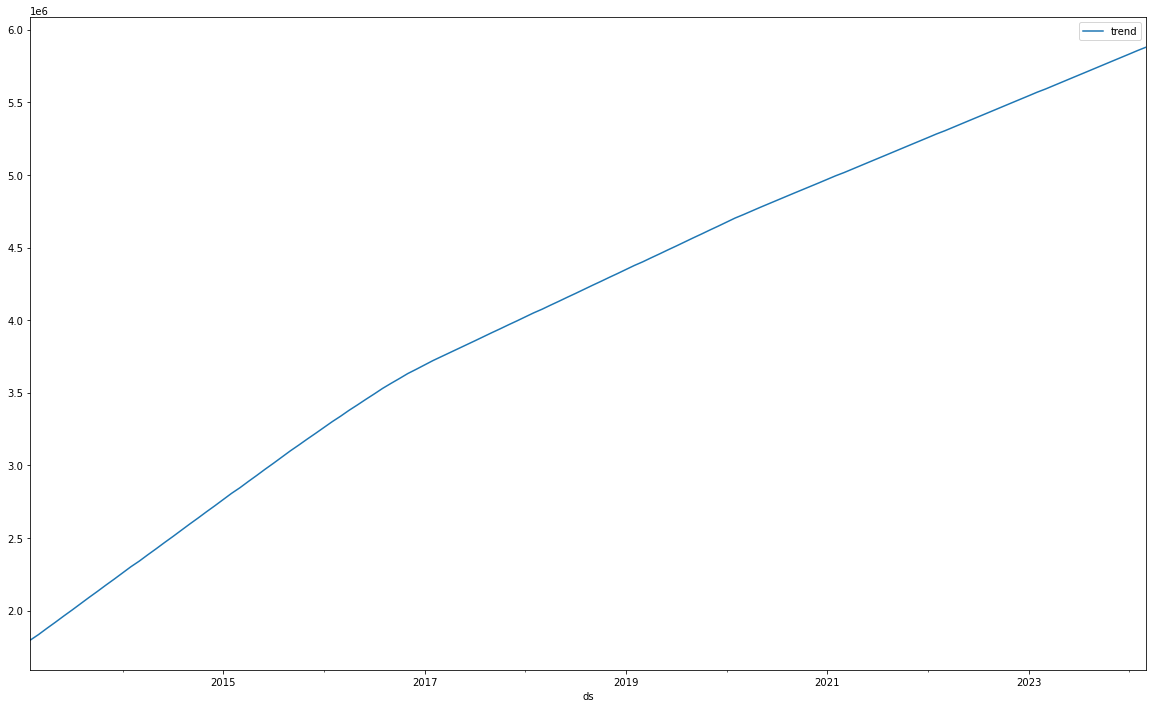

In [ ]:
fig2 = m.plot_components(forecast)
ax = pd.DataFrame(forecast['trend']).set_index(forecast['ds']).plot(figsize=(20, 12))

In [ ]:
# tahmin edilen değerlerin grafik gösterimi için hazırlık

ds = forecast['ds']
yhat = forecast['yhat']
forecastnew = pd.concat([ds,yhat], axis=1)
mask = (forecastnew['ds'] > "2022-03-01") & (forecastnew['ds'] <= "2024-03-01")
predict_values = forecastnew.loc[mask]
mask = (forecastnew['ds'] >= "2013-02-01") & (forecastnew['ds'] <= "2022-03-01")
forecastnew = forecastnew.loc[mask]
values = pd.merge(df, pd.DataFrame(forecast['ds']), how = 'outer',  on = 'ds')

In [ ]:
# Prophet library ile tahmini yapılmış ayların alt, üst sınırları ve tahmin değerleri tablosu

predicted_months = forecast[forecast['ds']>'2022-03-01'][['ds','yhat_upper','yhat_lower','yhat']]
predicted_months

,ds,yhat_upper,yhat_lower,yhat
110,2022-04-01,5577613,5035550,5306594
111,2022-05-01,5663945,5107944,5370352
112,2022-06-01,5685763,5086807,5377256
113,2022-07-01,5728126,5202051,5465118
114,2022-08-01,5800073,5248859,5517523
115,2022-09-01,5737014,5184310,5464365
116,2022-10-01,5765312,5226066,5506696
117,2022-11-01,5803723,5237319,5518246
118,2022-12-01,5889874,5337487,5616381
119,2023-01-01,5808240,5267315,5542136


Yellow = Upper_yhat Green = Lower_yhat Black = Original values Red = Predicted Values, Blue = Base Values(Yhat)


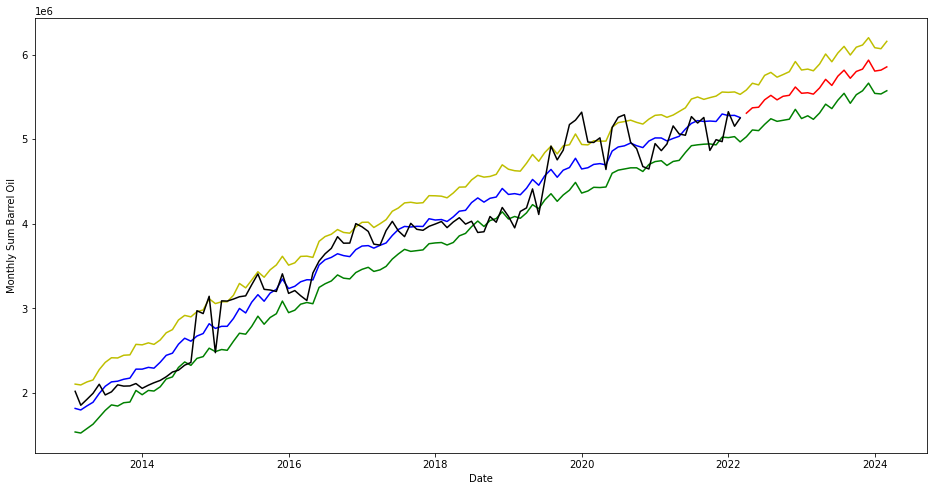

In [ ]:
# Prophet library ile tahmin edilmiş ve orijinal değerlerin gösterimi

fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(forecastnew.set_index('ds'), color='b')
ax1.plot(pd.DataFrame(forecast['yhat_lower']).set_index(forecast['ds']), color='g')
ax1.plot(pd.DataFrame(forecast['yhat_upper']).set_index(forecast['ds']), color='y')
ax1.plot(values.set_index('ds'), color='k')
ax1.plot(predict_values.set_index('ds'), color='r')
ax1.set_ylabel('Monthly Sum Barrel Oil')
ax1.set_xlabel('Date')
print('Yellow = Upper_yhat','Green = Lower_yhat', 'Black = Original values', "Red = Predicted Values, Blue = Base Values(Yhat)")

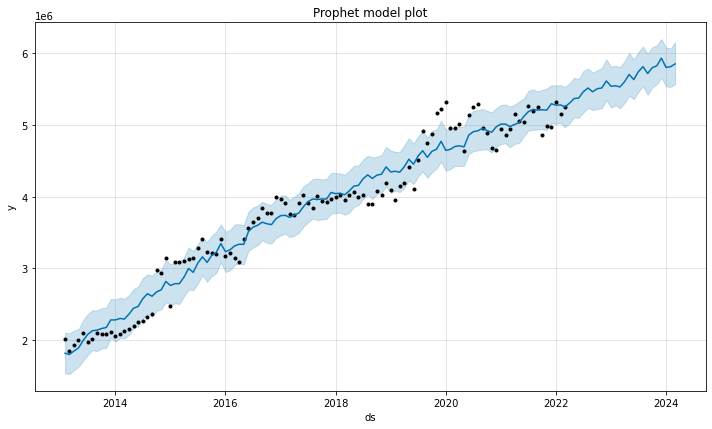

In [ ]:
# Prophet modelinin hazır grafik gösterimi
m.plot(forecast)
plt.title('Prophet model plot')
pl2 = plt.show()
pl2

In [ ]:
# modelin metrikleri

print(mean_squared_error(df.y,forecast.head(110)['yhat']))
print(mean_absolute_error(df.y,forecast.head(110)['yhat']))
print(mean_absolute_percentage_error(df.y,forecast.head(110)['yhat']))
print(r2_score(df.y,forecast.head(110)['yhat']))

46639961341.9966
177165.8899606352
0.05032680609149977
0.9570427032705945
